In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.1 MB/s eta 0:00:00


In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks

/content/drive/MyDrive/Colab_Notebooks


## Preprocess

In [ ]:
df_total = pd.read_csv('train.csv')
df_test_total = pd.read_csv('test.csv')

# Drop date, because date highly possibly doesn't overlap
# df = df.drop('Date', axis=1)
# df_test = df_test.drop('Date', axis=1)

In [ ]:
# Check if there is a column with too much nan that can be discarded
print(df.isna().sum())
print('-------------------')
print(df_test.isna().sum())

In [ ]:
# label encoder fit in train and transform on test
labelencoder = sklearn.preprocessing.LabelEncoder()
df['Loc'] = labelencoder.fit_transform(df['Loc'])
df_test['Loc'] = labelencoder.transform(df_test['Loc'])

In [ ]:
# wind direction to 2-d coordinates
direction_degrees = {"N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5, "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5, "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5, "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5}
for col in ['WindDir', 'DayWindDir', 'NightWindDir']:
  cosine = []
  sine = []
  df[col] = df[col].fillna('NA')
  df_test[col] = df_test[col].fillna('NA')
  for i in range(len(df)):
    if df.loc[i,col] != 'NA':
      wind_degrees = direction_degrees[df.loc[i,col]]
      cosine.append(np.cos(np.deg2rad(wind_degrees)))
      sine.append(np.sin(np.deg2rad(wind_degrees)))
    else:
      cosine.append(np.nan)
      sine.append(np.nan)
  df[col+'cosine'] = cosine
  df[col+'sine'] = sine
  df = df.drop(col, axis=1)
  cosine = []
  sine = []
  for i in range(len(df_test)):
    if df_test.loc[i,col] != 'NA':
      wind_degrees = direction_degrees[df_test.loc[i,col]]
      cosine.append(np.cos(np.deg2rad(wind_degrees)))
      sine.append(np.sin(np.deg2rad(wind_degrees)))
    else:
      cosine.append(np.nan)
      sine.append(np.nan)
  df_test[col+'cosine'] = cosine
  df_test[col+'sine'] = sine
  df_test = df_test.drop(col, axis=1)

In [ ]:
with open('loc_dic_1.pickle', 'rb') as f:
    location = pickle.load(f)

[]

In [ ]:
df['Loc'] = df['Loc'].fillna('NA')
df_test['Loc'] = df_test['Loc'].fillna('NA')
longtitude = []
latitude = []
for i in range(len(df)):
  if df.loc[i,'Loc'] != 'NA' and len(location[df.loc[i, 'Loc']]) > 0:
    latitude.append(location[df.loc[i, 'Loc']][0]['geometry']['location']['lat'])
    longtitude.append(location[df.loc[i, 'Loc']][0]['geometry']['location']['lng'])
  else:
      latitude.append(np.nan)
      longtitude.append(np.nan)
df['latitude'] = latitude
df['longtitude'] = longtitude
df = df.drop('Loc', axis = 1)

longtitude = []
latitude = []
for i in range(len(df_test)):
  if df_test.loc[i,'Loc'] != 'NA' and len(location[df_test.loc[i, 'Loc']]) > 0:
    latitude.append(location[df_test.loc[i, 'Loc']][0]['geometry']['location']['lat'])
    longtitude.append(location[df_test.loc[i, 'Loc']][0]['geometry']['location']['lng'])
  else:
      latitude.append(np.nan)
      longtitude.append(np.nan)
df_test['latitude'] = latitude
df_test['longtitude'] = longtitude
df_test = df_test.drop('Loc', axis = 1)

In [ ]:
df.to_csv('train_longlat_winddir.csv',  index = False)
df_test.to_csv('test_longlat_winddir.csv',  index = False)

In [ ]:
def date_to_cyclic_feature(df_, column_name):
    df_[column_name] = pd.to_datetime(df_[column_name])
    df_[column_name + '_sin'] = np.sin(2 * np.pi * df_[column_name].dt.dayofyear / 365.25)
    df_[column_name + '_cos'] = np.cos(2 * np.pi * df_[column_name].dt.dayofyear / 365.25)
    return df_

df_new = date_to_cyclic_feature(df_total, 'Date')
df_test_new = date_to_cyclic_feature(df_test_total, 'Date')
df_new.head()

,Date,Loc,TempLow,TempHigh,Steaming,Sun,WindDir,WindSpeed,DayWindDir,NightWindDir,...,DayPressure,NightPressure,DayCloud,NightCloud,DayTemp,NightTemp,Weather,RISK_MM,Date_sin,Date_cos
0,2016-07-19,NaN,19.5,NaN,5.69496,0.500000,ENE,61.0,ENE,ENE,...,1020.4,1021.9,NaN,7.00000,NaN,19.6,0,NaN,-0.310857,-0.950457
1,2010-07-26,Canberra,2.1,15.7,NaN,5.700000,E,26.0,NaN,SE,...,1023.7,1020.8,4.000000,1.00000,9.0,14.1,0,0.0,-0.407129,-0.913370
2,2014-04-02,Woomera,20.9,36.1,5.69496,NaN,S,39.0,S,SW,...,1017.1,1014.9,4.167266,4.27812,24.2,33.9,0,0.0,0.999930,-0.011826
3,2014-11-19,Tuggeranong,11.5,23.9,5.69496,7.993227,NNE,35.0,W,NaN,...,1010.2,NaN,4.167266,4.27812,13.8,21.8,1,0.2,-0.664483,0.747303
4,NaT,Hobart,8.2,20.5,3.20000,NaN,N,69.0,N,WNW,...,NaN,1001.2,7.000000,7.00000,NaN,17.6,0,0.6,NaN,NaN


In [ ]:
df['Date'+'_sin'] = df_new['Date'+'_sin']
df['Date'+'_cos'] = df_new['Date'+'_cos']
df_test['Date'+'_sin'] = df_test_new['Date'+'_sin']
df_test['Date'+'_cos'] = df_test_new['Date'+'_cos']
df.to_csv('train_longlat_winddir_date.csv',  index = False)
df_test.to_csv('test_longlat_winddir_date.csv',  index = False)

## Load Preproceesed

In [ ]:
df = pd.read_csv('train_longlat_winddir_date.csv')
df_test = pd.read_csv('test_longlat_winddir_date.csv')
# df = df.drop('Unnamed: 0', axis=1)
# df_test = df_test.drop('Unnamed: 0', axis=1)
df_test.head()

,TempLow,TempHigh,Steaming,Sun,WindSpeed,DayWindSpeed,NightWindSpeed,DayHumidity,NightHumidity,DayPressure,...,WindDircosine,WindDirsine,DayWindDircosine,DayWindDirsine,NightWindDircosine,NightWindDirsine,latitude,longtitude,Date_sin,Date_cos
0,6.9,23.5,5.69496,NaN,41.0,11.0,26.0,43.950026,NaN,1028.00000,...,1.000000,0.000000,0.923880,0.382683,1.000000,0.000000,-37.562159,143.850256,-0.359472,-0.933156
1,4.2,21.5,5.69496,7.993227,35.0,NaN,15.0,34.682783,63.653409,1018.03427,...,0.382683,-0.923880,NaN,NaN,NaN,NaN,-32.980419,121.645607,NaN,NaN
2,24.4,39.6,14.60000,NaN,44.0,26.0,24.0,9.820135,45.476982,1014.10000,...,-0.923880,0.382683,-0.923880,-0.382683,NaN,NaN,-23.698042,133.880747,NaN,NaN
3,10.8,21.5,5.69496,7.993227,39.0,NaN,NaN,49.095435,48.865800,NaN,...,0.382683,-0.923880,-0.923880,0.382683,NaN,NaN,-41.439068,147.135767,-0.484089,-0.875019
4,27.3,NaN,4.40000,3.500000,28.0,15.0,20.0,66.034683,64.548346,1012.80000,...,0.707107,-0.707107,-0.707107,-0.707107,0.707107,-0.707107,NaN,NaN,NaN,NaN


## Train_Valid_Split

In [ ]:
# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# Q3['Weather'] = 1
# IQR = Q3 - Q1
# print(IQR)
# df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))]
# print(df_out.shape)

TempLow                9.300000
TempHigh              10.400000
Steaming               1.294960
Sun                    1.206773
WindSpeed             15.000000
DayWindSpeed          12.000000
NightWindSpeed        11.000000
DayHumidity           23.267037
NightHumidity         14.010180
DayPressure            8.200000
NightPressure          8.400000
DayCloud               3.000000
NightCloud             3.000000
DayTemp                9.300000
NightTemp              9.750000
Weather                1.000000
RISK_MM                0.200000
WindDircosine          1.414214
WindDirsine            1.414214
DayWindDircosine       1.414214
DayWindDirsine         1.414214
NightWindDircosine     1.414214
NightWindDirsine       1.414214
latitude               6.383565
longtitude            15.960820
dtype: float64
(35156, 25)


In [ ]:
df.shape

(35156, 25)

In [ ]:
y = df_out['Weather']
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    df_out.drop(columns = ['Weather']), df_out['Weather'], test_size=0.2, stratify = y)
X_test = df_test

In [ ]:
y = df['Weather']
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    df.drop(columns = ['Weather']), df['Weather'], test_size=0.2, stratify = y)
X_test = df_test

In [ ]:
# for col in X_train.columns:
#   fill = X_train[col].median()
#   if fill == np.nan:
#     fill = X_train[col].mode()
#   X_train[col] = X_train[col].fillna(fill)
#   X_val[col] = X_val[col].fillna(fill)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
for feature in X_train.columns:
    X_train_scaled[X_train[feature].isna(), X_train.columns.get_loc(feature)] = float('nan')
for feature in X_val.columns:
    X_val_scaled[X_val[feature].isna(), X_val.columns.get_loc(feature)] = float('nan')

In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
# imputer = KNNImputer(n_neighbors=4, weights="uniform")
imputer = IterativeImputer(random_state=0)
X_train_imp = imputer.fit_transform(X_train_scaled)
X_val_imp = imputer.transform(X_val_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
# fill na with median
# for col in X_train.columns:
#   fill = X_train[col].median()
#   if fill == np.nan:
#     fill = X_train[col].mode()
#   X_train[col] = X_train[col].fillna(fill)
#   X_val[col] = X_val[col].fillna(fill)

In [ ]:
# !pip install crucio
# from crucio import MWMOTE
# df_train = pd.DataFrame(X_train)
# df_train['Weather'] = y_train
# df_train = df_train.dropna()
# mwmote = MWMOTE()
# balanced_df = mwmote.balance(df_train, 'Weather')

In [ ]:
# X_train_sm, y_train_sm = np.array(balanced_df.drop(columns = ['Weather'])), np.array(balanced_df['Weather'])

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN
sm = BorderlineSMOTE(random_state=42, kind='borderline-1')
sm = SMOTEENN()
X_train_sm, y_train_sm = sm.fit_resample(X_train_imp, y_train)

In [ ]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [ ]:
# scaler = sklearn.preprocessing.StandardScaler().fit(np.array(X_train_sm))
# X_train_scaled = scaler.transform(np.array(X_train_sm))
# X_val_scaled = scaler.transform(np.array(X_val))

In [ ]:
print(X_train_scaled.shape)

(50354, 24)


In [ ]:
# pca = sklearn.decomposition.PCA(n_components = 0.9)
# X_train_scaled = pca.fit_transform(X_train_scaled)
# X_val_scaled = pca.transform(X_val_scaled)

In [ ]:
xgboostModel = XGBClassifier(n_estimators=100,learning_rate=0.01)
xgboostModel.fit(X_train_sm, y_train_sm)
predicted = xgboostModel.predict(X_val_scaled)

print('Accuracy: %f' % accuracy_score(y_val, predicted))
print('f1-score: %f' % f1_score(y_val, predicted))

Accuracy: 0.806314
f1-score: 0.332353


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

clf2 = LogisticRegression()
clf4 = RandomForestClassifier(n_estimators=100, random_state=42)
clf5 = XGBClassifier(n_estimators=100, max_depth=20, learning_rate=0.01)
clf6 = svm.SVC()
clf7 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=200)
clf8 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
clf9 = LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
clf10 = CatBoostClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
clf11 = ExtraTreesClassifier(n_estimators=200, random_state=42)
clf12 = BaggingClassifier(n_estimators=200, random_state=42)
clf13 = GaussianNB()

# Define the voting classifier
ensemble_clf = VotingClassifier(estimators=[
                            ('lr', clf2),
                            ('rf1', RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)),
                            ('XGB2', XGBClassifier(n_estimators=200, max_depth=20, learning_rate=0.01)),
                            ('svm', clf6),
                            ('ada', clf7),
                            ('gb', clf8),
                            ('lgbm', clf9),
                            ('cat', clf10),
                            ('ext', clf11),
                            ('bag', clf12),
                            ('gnb', clf13)
                           ], voting='hard',verbose=True)

# Train the classifier
ensemble_clf.fit(X_train_sm, y_train_sm)

# Make predictions on the validation set
y_pred_decision = ensemble_clf.predict(X_val_imp)

# Evaluate the classifier
print('Accuracy: %f' % accuracy_score(y_val, y_pred_decision))
print('f1-score: %f' % f1_score(y_val, y_pred_decision))

[Voting] ...................... (1 of 11) Processing lr, total=   0.5s
[Voting] ..................... (2 of 11) Processing rf1, total=  56.2s
[Voting] .................... (3 of 11) Processing XGB2, total= 3.1min
[Voting] ..................... (4 of 11) Processing svm, total= 1.4min


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] ..................... (5 of 11) Processing ada, total=  23.6s
[Voting] ...................... (6 of 11) Processing gb, total= 1.3min
[Voting] .................... (7 of 11) Processing lgbm, total=   2.5s
0:	learn: 0.6469582	total: 10.5ms	remaining: 2.08s
1:	learn: 0.6102797	total: 19.6ms	remaining: 1.94s
2:	learn: 0.5830279	total: 28.4ms	remaining: 1.86s
3:	learn: 0.5583559	total: 37.4ms	remaining: 1.83s
4:	learn: 0.5399658	total: 46.8ms	remaining: 1.83s
5:	learn: 0.5249396	total: 56.7ms	remaining: 1.83s
6:	learn: 0.5122869	total: 65.4ms	remaining: 1.8s
7:	learn: 0.5016109	total: 75.1ms	remaining: 1.8s
8:	learn: 0.4928048	total: 84ms	remaining: 1.78s
9:	learn: 0.4857798	total: 93.5ms	remaining: 1.78s
10:	learn: 0.4783482	total: 107ms	remaining: 1.85s
11:	learn: 0.4724306	total: 119ms	remaining: 1.86s
12:	learn: 0.4665665	total: 129ms	remaining: 1.85s
13:	learn: 0.4590749	total: 139ms	remaining: 1.85s
14:	learn: 0.4479883	total: 149ms	remaining: 1.84s
15:	learn: 0.4437514	total

In [ ]:
len(ensemble_clf.estimators_)

12

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

clf0 = XGBClassifier(n_estimators=100,learning_rate=0.01)
clf1 = DecisionTreeClassifier()
clf2 = LogisticRegression()
clf3 = KNeighborsClassifier()
clf4 = LGBMClassifier(objective = 'binary', learning_rate = 0.01, n_estimators = 100)
clf5 = SVC()
model = MLPClassifier(hidden_layer_sizes = (16), activation = 'relu', solver = 'adam', alpha = 1e-5, batch_size = 16, learning_rate = 'constant', verbose = False)

ensemble_clf = VotingClassifier(estimators=[('xgb', clf0), ('dt', clf1), ('lr', clf2), ('knn', clf3), ('lgb', clf4), ('svm', clf5)], voting='hard')
ensemble_clf.fit(X_train_scaled, y_train_sm)
y_pred = ensemble_clf.predict(X_train_scaled)
print('Accuracy: %f' % accuracy_score(y_train_sm, y_pred))
print('f1-score: %f' % f1_score(y_train_sm, y_pred))
y_pred = ensemble_clf.predict(X_val_scaled)
print('Accuracy: %f' % accuracy_score(y_val, y_pred))
print('f1-score: %f' % f1_score(y_val, y_pred))

Accuracy: 0.925150
f1-score: 0.924721
Accuracy: 0.855660
f1-score: 0.411594


In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils

def keras_model(neurons=1, optimizer="adam", hidden_layers=1, dropout_rate=0.0):
    model = Sequential()

    # Add an input layer
    model.add(Dense(1024, input_dim=24, activation="relu"))

    for i in range(hidden_layers):
      # Add one hidden layer
      model.add(Dense(neurons, activation="relu"))

    model.add(Dropout(dropout_rate))

    # Add an output layer
    model.add(Dense(1, activation="sigmoid"))

    model.summary()

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

np.random.seed(42)

optimised_model = KerasClassifier(build_fn=keras_model, verbose=1)

parameters = {
    "neurons": [128, 256, 512],
    "optimizer": ["SGD", "RMSprop", "Adam"],
    "dropout_rate": [0.1, 0.2],
    "hidden_layers": [i for i in range(3,6)],
    "epochs": [30],
    "batch_size": [32],
}

# parameters = {
#     "neurons": [256],
#     "optimizer": ["Adam"],
#     "dropout_rate": [0.2],
#     "hidden_layers": [3],
#     "epochs": [30],
#     "batch_size": [32],
# }

grid = GridSearchCV(
    optimised_model,
    parameters,
    cv=5,
    n_jobs=-1,
    scoring="f1_micro",
    verbose=1,
)

grid_result = grid.fit(X_train_scaled, y_train_sm)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
y_pred = grid_result.predict(X_val_scaled)

print("Precision Score :", precision_score(y_val, y_pred))
print("Recall Score:", recall_score(y_val, y_pred))
print("f1 Score:", f1_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print("")

Fitting 5 folds for each of 54 candidates, totalling 270 fits


<ipython-input-9-e59e71739481>:33: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  optimised_model = KerasClassifier(build_fn=keras_model, verbose=1)
/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils

def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


model = Sequential()
model.add(Dense(1024, input_dim=24, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[F1])

training = model.fit(x=X_train_scaled, y=y_train_sm, batch_size=32, epochs=40, shuffle=True, verbose=1)

y_pred = model.predict(X_val_scaled)
for i in y_pred:
  if i[0] > 0.5:
    i[0] = 1
  else:
    i[0] = 0
print("Precision Score :", precision_score(y_val, y_pred))
print("Recall Score:", recall_score(y_val, y_pred))
print("f1 Score:", f1_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print("")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              25600     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2

ValueError: ignored

In [ ]:
y_pred = model.predict(X_val_scaled)
for i in y_pred:
  if i[0] > 0.5:
    i[0] = 1
  else:
    i[0] = 0
print("Precision Score :", precision_score(y_val, y_pred))
print("Recall Score:", recall_score(y_val, y_pred))
print("f1 Score:", f1_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print("")

220/220 [==============================] - 0s 2ms/step
Precision Score : 0.418705035971223
Recall Score: 0.3948439620081411
f1 Score: 0.4064245810055866
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6295
           1       0.42      0.39      0.41       737

    accuracy                           0.88      7032
   macro avg       0.67      0.67      0.67      7032
weighted avg       0.88      0.88      0.88      7032




In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = RandomForestClassifier(n_estimators=100, max_depth = 5, random_state=42)
rf.fit(X_train_sm, y_train_sm)

y_pred_decision = rf.predict(X_train_sm)
print('Accuracy: %f' % accuracy_score(y_train_sm, y_pred_decision))
print('f1-score: %f' % f1_score(y_train_sm, y_pred_decision))
y_pred_decision = rf.predict(X_val_imp)
print('Accuracy: %f' % accuracy_score(y_val, y_pred_decision))
print('f1-score: %f' % f1_score(y_val, y_pred_decision))

Accuracy: 0.838206
f1-score: 0.842573
Accuracy: 0.788254
f1-score: 0.380358


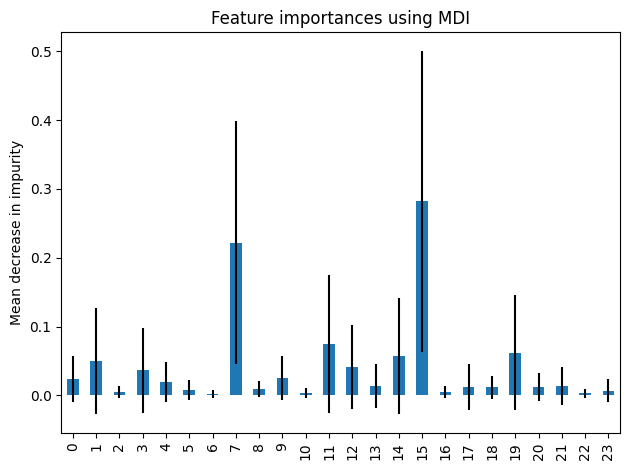

In [ ]:
import matplotlib.pyplot as plt
importances = rf.feature_importances_
forest_importances = pd.Series(importances)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
print(X_train.columns)

Index(['Loc', 'TempLow', 'TempHigh', 'Steaming', 'Sun', 'WindSpeed',
       'DayWindSpeed', 'NightWindSpeed', 'DayHumidity', 'NightHumidity',
       'DayPressure', 'NightPressure', 'DayCloud', 'NightCloud', 'DayTemp',
       'NightTemp', 'RISK_MM', 'WindDircosine', 'WindDirsine',
       'DayWindDircosine', 'DayWindDirsine', 'NightWindDircosine',
       'NightWindDirsine'],
      dtype='object')


## Train On All

In [ ]:
X_train = df.copy()
X_test = df_test.copy()
X_train, y_train = X_train.drop(columns = ['Weather']), X_train['Weather']
# X_train, y_train = X_train.drop(columns = ['Weather', 'Date_sin', 'Date_cos']), X_train['Weather']
# X_test = X_test.drop(columns = ['Date_sin', 'Date_cos'])

In [ ]:
scaler = sklearn.preprocessing.StandardScaler().fit(np.array(X_train))
X_train_scaled = scaler.transform(np.array(X_train))
X_test_scaled = scaler.transform(np.array(X_test))
for feature in X_train.columns:
    X_train_scaled[X_train[feature].isna(), X_train.columns.get_loc(feature)] = float('nan')
for feature in X_test.columns:
    X_test_scaled[X_test[feature].isna(), X_test.columns.get_loc(feature)] = float('nan')

In [ ]:
imputer = IterativeImputer(random_state=0)
# imputer = KNNImputer(n_neighbors=4, weights="uniform")
X_train_imp = imputer.fit_transform(X_train_scaled)
X_test_imp = imputer.transform(X_test_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=10)
# X_train_imp = pca.fit_transform(X_train_imp)
# X_test_imp = pca.transform(X_test_imp)

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=42, kind='borderline-1')
from imblearn.combine import SMOTEENN
sm = SMOTEENN()
X_train_sm, y_train_sm = sm.fit_resample(X_train_imp, y_train)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from imblearn.ensemble import RUSBoostClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier, BalancedRandomForestClassifier

clf2 = LogisticRegression()
clf4 = RandomForestClassifier(n_estimators=100, random_state=42)
clf5 = XGBClassifier(n_estimators=100, max_depth=20, learning_rate=0.01)
clf6 = svm.SVC()
clf7 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=200)
clf8 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
clf9 = LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
clf10 = CatBoostClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
clf11 = ExtraTreesClassifier(n_estimators=200, random_state=42)
clf12 = BaggingClassifier(n_estimators=200, random_state=42)
clf13 = GaussianNB()

clf14 = RUSBoostClassifier(random_state=42)
clf15 = EasyEnsembleClassifier(random_state=42)
clf16 = BalancedBaggingClassifier()
clf17 = BalancedRandomForestClassifier(max_depth = 20)
# Define the voting classifier
ensemble_clf = VotingClassifier(estimators=[
                            ('lr', clf2),
                            # ('rf1', RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)),
                            ('XGB2', XGBClassifier(n_estimators=200, max_depth=20, learning_rate=0.01)),
                            ('svm', clf6),
                            ('ada', clf7),
                            ('gb', clf8),
                            ('lgbm', clf9),
                            ('cat', clf10),
                            ('ext', clf11),
                            # ('bag', clf12),
                            ('gnb', clf13),
                            ('RUS', clf14),
                            ('eec', clf15),
                            ('bbg', clf16),
                            ('brf', clf17)
                           ], voting='hard',verbose=True)
# Train the classifier
ensemble_clf.fit(X_train_sm, y_train_sm)

# Make predictions on the validation set
y_pred_decision = ensemble_clf.predict(X_test_imp)

[Voting] ...................... (1 of 13) Processing lr, total=   0.3s
[Voting] .................... (2 of 13) Processing XGB2, total= 2.4min
[Voting] ..................... (3 of 13) Processing svm, total=  56.0s


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[Voting] ..................... (4 of 13) Processing ada, total=  32.2s
[Voting] ...................... (5 of 13) Processing gb, total= 1.3min
[Voting] .................... (6 of 13) Processing lgbm, total=   1.0s
0:	learn: 0.6321394	total: 10.1ms	remaining: 2s
1:	learn: 0.5816867	total: 19.2ms	remaining: 1.9s
2:	learn: 0.5444964	total: 28.2ms	remaining: 1.85s
3:	learn: 0.5136409	total: 37.6ms	remaining: 1.84s
4:	learn: 0.4884024	total: 49.4ms	remaining: 1.93s
5:	learn: 0.4679913	total: 58.8ms	remaining: 1.9s
6:	learn: 0.4520764	total: 68.4ms	remaining: 1.89s
7:	learn: 0.4402979	total: 81.5ms	remaining: 1.96s
8:	learn: 0.4295702	total: 91.3ms	remaining: 1.94s
9:	learn: 0.4196996	total: 101ms	remaining: 1.92s
10:	learn: 0.4113516	total: 111ms	remaining: 1.91s
11:	learn: 0.4047758	total: 120ms	remaining: 1.88s
12:	learn: 0.3988888	total: 130ms	remaining: 1.87s
13:	learn: 0.3920569	total: 140ms	remaining: 1.86s
14:	learn: 0.3860636	total: 149ms	remaining: 1.84s
15:	learn: 0.3806598	total: 

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel

[Voting] .................... (13 of 13) Processing brf, total=  20.3s


In [ ]:
df_sap = pd.DataFrame(y_pred_decision.astype(int), columns = ['Weather'])
df_sap.to_csv('myAns.csv',  index_label = 'Id')

# ================================================
## Geo + Drop na in RISK_MM

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my-custom-user-agent")
geo_dict = {}

def get_location(row):
    if row['Loc'] != 'NA':
      if row['Loc'] in geo_dict.keys():
        row['longitude'] = geo_dict[row['Loc']]['longitude']
        row['latitude'] = geo_dict[row['Loc']]['latitude']
        return row
      location = geolocator.geocode(row['Loc'])
      if location == None:
        row['longitude'] = np.nan
        row['latitude'] = np.nan
        geo_dict[row['Loc']] = {}
        geo_dict[row['Loc']]['longitude'] = np.nan
        geo_dict[row['Loc']]['latitude'] = np.nan
      else:
        geo_dict[row['Loc']] = {}
        geo_dict[row['Loc']]['longitude'] = location.longitude
        geo_dict[row['Loc']]['latitude'] = location.latitude
        row['longitude'] = location.longitude
        row['latitude'] = location.latitude
    else:
      row['longitude'] = np.nan
      row['latitude'] = np.nan

    return row

df['Loc'] = df['Loc'].fillna('NA')
# print(nom.geocode('NorahHead'))
df = df.apply(get_location, axis=1)
df = df.drop('Loc', axis=1)
df.head()

,TempLow,TempHigh,Steaming,Sun,WindDir,WindSpeed,DayWindDir,NightWindDir,DayWindSpeed,NightWindSpeed,...,DayPressure,NightPressure,DayCloud,NightCloud,DayTemp,NightTemp,Weather,RISK_MM,longitude,latitude
0,19.5,NaN,5.69496,0.500000,ENE,61.0,ENE,ENE,31.0,22.0,...,1020.4,1021.9,NaN,7.00000,NaN,19.6,0,NaN,NaN,NaN
1,2.1,15.7,NaN,5.700000,E,26.0,NaN,SE,9.0,7.0,...,1023.7,1020.8,4.000000,1.00000,9.0,14.1,0,0.0,149.101268,-35.297591
2,20.9,36.1,5.69496,NaN,S,39.0,S,SW,31.0,17.0,...,1017.1,1014.9,4.167266,4.27812,24.2,33.9,0,0.0,136.825353,-31.199914
3,11.5,23.9,5.69496,7.993227,NNE,35.0,W,NaN,7.0,17.0,...,1010.2,NaN,4.167266,4.27812,13.8,21.8,1,0.2,149.092134,-35.420977
4,8.2,20.5,3.20000,NaN,N,69.0,N,WNW,NaN,NaN,...,NaN,1001.2,7.000000,7.00000,NaN,17.6,0,0.6,147.328123,-42.882509


In [ ]:
df_test['Loc'] = df_test['Loc'].fillna('NA')
# print(nom.geocode('NorahHead'))
df_test = df_test.apply(get_location, axis=1)
df_test = df_test.drop('Loc', axis=1)
df_test.head()

,TempLow,TempHigh,Steaming,Sun,WindDir,WindSpeed,DayWindDir,NightWindDir,DayWindSpeed,NightWindSpeed,...,NightHumidity,DayPressure,NightPressure,DayCloud,NightCloud,DayTemp,NightTemp,RISK_MM,longitude,latitude
0,6.9,23.5,5.69496,NaN,N,41.0,NNE,N,11.0,26.0,...,NaN,1028.00000,1025.100000,1.000000,NaN,16.7,NaN,0.0,143.860565,-37.562303
1,4.2,21.5,5.69496,7.993227,WNW,35.0,NaN,NaN,NaN,15.0,...,63.653409,1018.03427,1015.465952,4.167266,4.27812,13.8,20.9,NaN,NaN,NaN
2,24.4,39.6,14.60000,NaN,SSE,44.0,SSW,NaN,26.0,24.0,...,45.476982,1014.10000,1010.400000,0.000000,2.00000,31.5,38.0,0.0,NaN,NaN
3,10.8,21.5,5.69496,7.993227,WNW,39.0,SSE,NaN,NaN,NaN,...,48.865800,NaN,1021.000000,NaN,NaN,NaN,19.9,NaN,147.137350,-41.434081
4,27.3,NaN,4.40000,3.500000,NW,28.0,SW,NW,15.0,20.0,...,64.548346,1012.80000,1008.200000,7.000000,7.00000,29.3,32.0,1.6,130.841047,-12.460440


In [ ]:
# wind direction to 2-d coordinates
direction_degrees = {"N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5, "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5, "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5, "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5}
for col in ['WindDir', 'DayWindDir', 'NightWindDir']:
  cosine = []
  sine = []
  df[col] = df[col].fillna('NA')
  df_test[col] = df_test[col].fillna('NA')
  for i in range(len(df)):
    if df.loc[i,col] != 'NA':
      wind_degrees = direction_degrees[df.loc[i,col]]
      cosine.append(np.cos(np.deg2rad(wind_degrees)))
      sine.append(np.sin(np.deg2rad(wind_degrees)))
    else:
      cosine.append(np.nan)
      sine.append(np.nan)
  df[col+'cosine'] = cosine
  df[col+'sine'] = sine
  df = df.drop(col, axis=1)
  cosine = []
  sine = []
  for i in range(len(df_test)):
    if df_test.loc[i,col] != 'NA':
      wind_degrees = direction_degrees[df_test.loc[i,col]]
      cosine.append(np.cos(np.deg2rad(wind_degrees)))
      sine.append(np.sin(np.deg2rad(wind_degrees)))
    else:
      cosine.append(np.nan)
      sine.append(np.nan)
  df_test[col+'cosine'] = cosine
  df_test[col+'sine'] = sine
  df_test = df_test.drop(col, axis=1)

In [ ]:
df.to_csv('train_longlat_winddir.csv')
df_test.to_csv('test_longlat_winddir.csv')

In [ ]:
df = df.dropna(subset=['RISK_MM'])

In [ ]:
y = df['Weather']
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    df.drop(columns = ['Weather']), df['Weather'], test_size=0.2, stratify = y)
X_test = df_test

In [ ]:
# fill na with median
for col in X_train.columns:
  fill = X_train[col].median()
  if fill == np.nan:
    fill = X_train[col].mode()
  if col in ['longitude', 'latitude']:
    fill = X_train[col].mean()
  X_train[col] = X_train[col].fillna(fill)
  X_val[col] = X_val[col].fillna(fill)

In [ ]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [ ]:
scaler = sklearn.preprocessing.StandardScaler().fit(np.array(X_train_sm))
X_train_scaled = scaler.transform(np.array(X_train_sm))
X_val_scaled = scaler.transform(np.array(X_val))

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

clf0 = XGBClassifier(n_estimators=100,learning_rate=0.01)
clf1 = DecisionTreeClassifier()
clf2 = LogisticRegression()
clf3 = KNeighborsClassifier()
clf4 = LGBMClassifier(objective = 'binary', learning_rate = 0.01, n_estimators = 100)
clf5 = SVC()

ensemble_clf = VotingClassifier(estimators=[('xgb', clf0), ('dt', clf1), ('lr', clf2), ('knn', clf3), ('lgb', clf4), ('svm', clf5)], voting='hard')
ensemble_clf.fit(X_train_scaled, y_train_sm)
y_pred = ensemble_clf.predict(X_val_scaled)
print('Accuracy: %f' % accuracy_score(y_val, y_pred))
print('f1-score: %f' % f1_score(y_val, y_pred))

Accuracy: 0.873472
f1-score: 0.438679


In [ ]:
X_train = df.copy()
X_test = df_test.copy()
for col in X_train.columns:
  if col == 'Loc':
    fill = X_train[col].mode()
  elif col in ['longitude', 'latitude']:
    fill = X_train[col].mean()
  else:
    fill = X_train[col].median()
    if fill == np.nan:
      fill = X_train[col].mode()
  X_train[col] = X_train[col].fillna(fill)
  if col != 'Weather':
    X_test[col] = X_test[col].fillna(fill)

In [ ]:
X_train, y_train = X_train.drop(columns = ['Weather']), X_train['Weather']
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [ ]:
scaler = sklearn.preprocessing.StandardScaler().fit(np.array(X_train_sm))
X_train_scaled = scaler.transform(np.array(X_train_sm))
X_test_scaled = scaler.transform(np.array(X_test))

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

clf0 = XGBClassifier(n_estimators=100,learning_rate=0.01)
clf1 = DecisionTreeClassifier()
clf2 = LogisticRegression()
clf3 = KNeighborsClassifier()
clf4 = LGBMClassifier(objective = 'binary', learning_rate = 0.01, n_estimators = 100)
clf5 = SVC()

ensemble_clf = VotingClassifier(estimators=[('xgb', clf0), ('dt', clf1), ('lr', clf2), ('knn', clf3), ('lgb', clf4), ('svm', clf5)], voting='hard')
ensemble_clf.fit(X_train_scaled, y_train_sm)
y_pred = ensemble_clf.predict(X_test_scaled)

In [ ]:
df_sap = pd.DataFrame(y_pred.astype(int), columns = ['Weather'])
df_sap.to_csv('geomean_dropRISKna.csv',  index_label = 'Id')

In [ ]:
count = 0
for i in geo_dict.keys():
  if type(geo_dict[i]['longitude']) == float:
    print(geo_dict[i]['longitude'])
    count += 1
print(count)

149.1012676
136.8253532
149.0921341
147.3281233
nan
138.9939006
nan
-71.2538759
151.8427778
nan
150.893054
145.8344444
19.9999619
146.9135396
142.1624972
1.2378026
131.03696147470208
153.0234991
8.809348
151.2082848
115.8605801
nan
-2.749059585987326
nan
nan
144.9631608
10.0098056
147.1373496
-80.353534
nan
132.2635993
nan
144.2825931
145.083635
-3.90097323715792
-77.43428
143.8605649
nan
130.8410469
nan
146.8239537
145.7721854
nan
nan
-122.674194
138.5999312
nan
-1.6131572
115.1004768
49
